## Task 1

#### Propagation Model
#### Attitude Update
Given, $\omega_E = 7.2921157 * 10^{-5} \frac{rad}{s}$

$$
    \Omega_i^e = \begin{bmatrix}
0 & -\omega_E & 0 \\
\omega_E & 0 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}
$$

$$
    \omega_e^n = \begin{bmatrix}
    \frac{v_E}{R_E(L)+h} \\
    -\frac{v_N}{R_N(L)+h} \\
    -\frac{v_E tan(L)}{R_E(L)+h}
    \end{bmatrix}
$$
$$
    \Omega_e^n = [\omega_e^n \quad \Lambda] \\
    \Omega_i^b = [\omega_i^b \quad \Lambda]
$$
$$
    R_{b,t}^n \approx R_{b,t-1}^n (I_3 + \Omega_i^b dt) - (\Omega_i^e + \Omega_e^n)R_{b,t-1}^n dt
$$

#### Velocity Update
$$
    f_{n,t} \approx \frac{1}{2} (R_{b,t-1}^n + R_{b,t}^n) f_{b,t}
$$
$$
    v_{n,t} = v{n,t-1} + dt (f_{n,t} + g(L_{t-1},h_{t-1}) - (\Omega_{e,t-1}^n + 2\Omega_{i,t-1}^e)v_{n,t-1})
$$

#### Position Update
$$
    h_t = h_{t-1} - \frac{dt}{2} (v_{D,t-1} + v_{D,t}) \\
    L_t = L_{t-1} + \frac{dt}{2} \left( \frac{v_{N,t-1}}{R_N(L_{t-1})+h_{t-1}} + \frac{v_{N,t}}{R_N(L_{t-1})+h_{t}}  \right) \\
    \lambda_t = \lambda_{t-1} + \frac{dt}{2} \left( \frac{v_{E,t-1}}{(R_E(L_{t-1})+h_{t-1})cos(L_{t-1})} + \frac{v_{E,t}}{(R_E(L_{t})+h_{t})cos(L_t)}  \right) 
$$

In addition to the propagation step, error correction and bias modeling has to be performed to be used in Nonlinear Kalman Filter.

For error correction/feed-forward model, 
$$
    error = position(from-propagation) - gps position \\
    position = position(from-propagation) - error
$$
Model is defined as,
$$
    x = [L,\lambda,h,\phi,\theta,\psi,v_N,v_E,v_D,e_L,e_h,e_\lambda]
$$

For bias/feed-back,
Model is defined as,
$$
    x = [L,\lambda,h,\phi,\theta,\psi,v_N,v_E,v_D,b_{gx},b_{gy},b_{gz},b_{ax},b_{ay},b_{az}]
$$


## Task 2
#### Nonlinear Error State Implementation

Modifications made to UKF from assignment 3
1) The number of states is 12 which will correspond to change in the sizes of sigma points matrix and weights
2) In addition to propagation model, errors have to be added.
3) Covariance Matrix R is a 6x6 matrix which provides covariance for position and velocity.
4) Observation matrix changes to observe position and velocity, 
$$\begin{aligned}
    \boldsymbol{\mathcal{Z}}_{t|t-1} &= \boldsymbol{C}\boldsymbol{\mathcal{X}}_{t|t-1} \\
        &= \begin{bmatrix} \boldsymbol{I}_3 & \boldsymbol{0}_3 & \boldsymbol{0}_3 & \boldsymbol{0}_3 & \boldsymbol{0}_3 \\ 
        \boldsymbol{0}_3 & \boldsymbol{0}_3 & \boldsymbol{I}_3 & \boldsymbol{0}_3 & \boldsymbol{0}_3 \end{bmatrix}\boldsymbol{\mathcal{X}}_{t|t-1}
\end{aligned}
$$


## Task 3

#### Full State Implementation

The states are 15 in this case. Covariance (R) and Observation will be changed as explained in task 2.

## Task 4

d:\Spring 2024\Adv Nav\Codes\INS\ukf.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_points[i] = x + cov[i - 1]
d:\Spring 2024\Adv Nav\Codes\INS\ukf.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_points[n + i] = x - cov[i - 1]


Mean Haversine Distance:  2.0371045960126436e-08


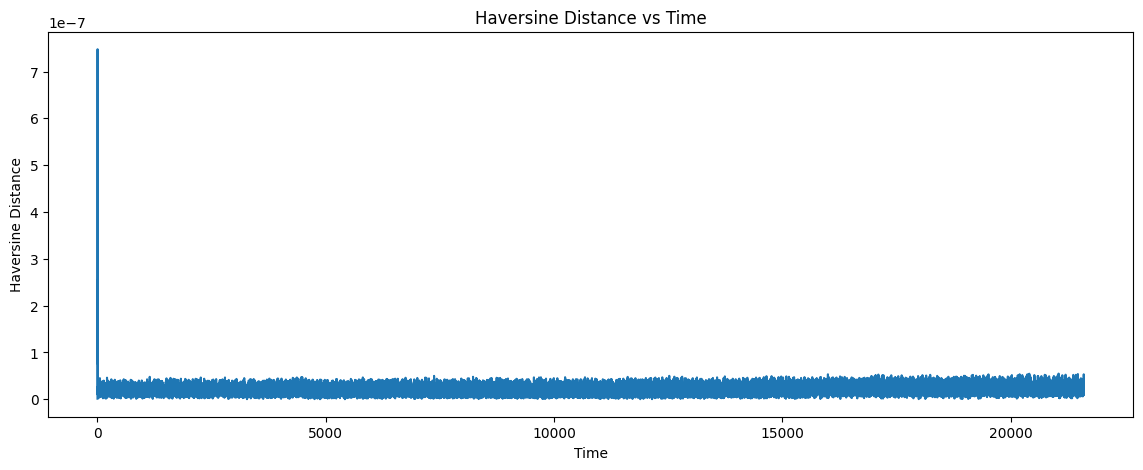

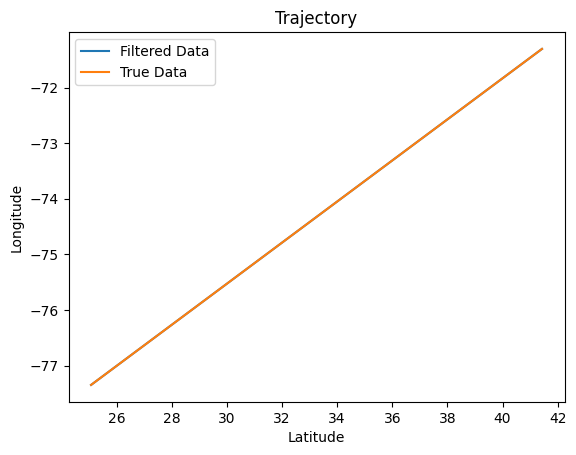

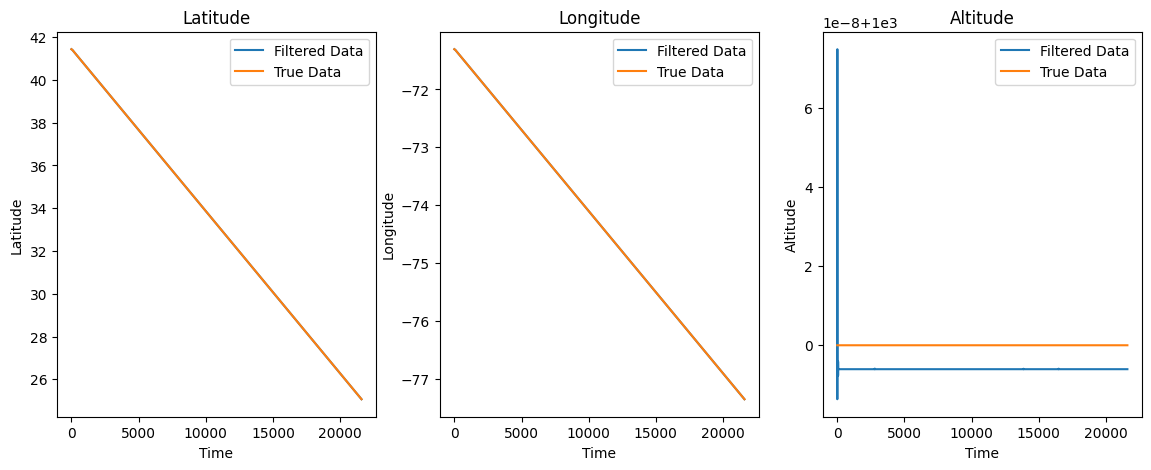

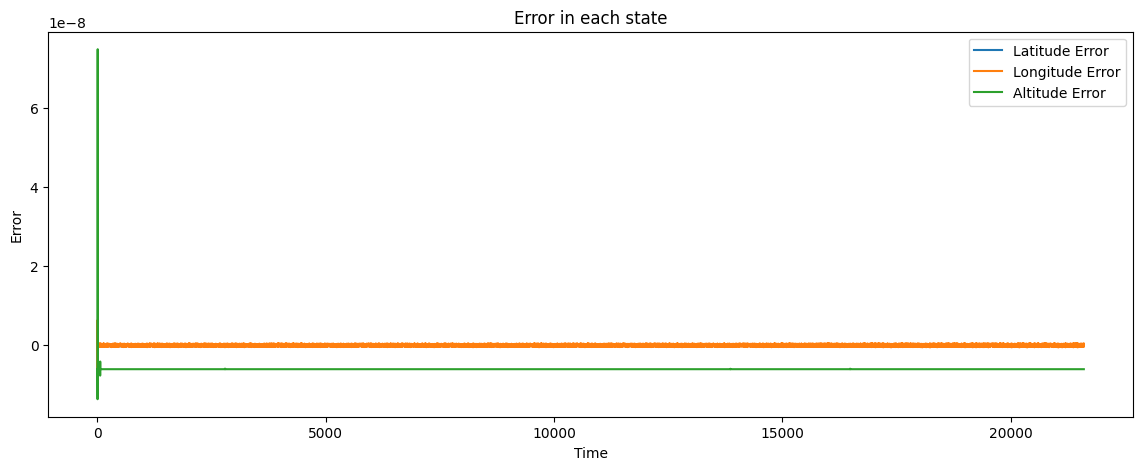

In [1]:
# Error State Implementation
import simulation

simulation.simulate(r"trajectory_data.csv","error_state")

Mean Haversine Distance:  0.21400548015171778


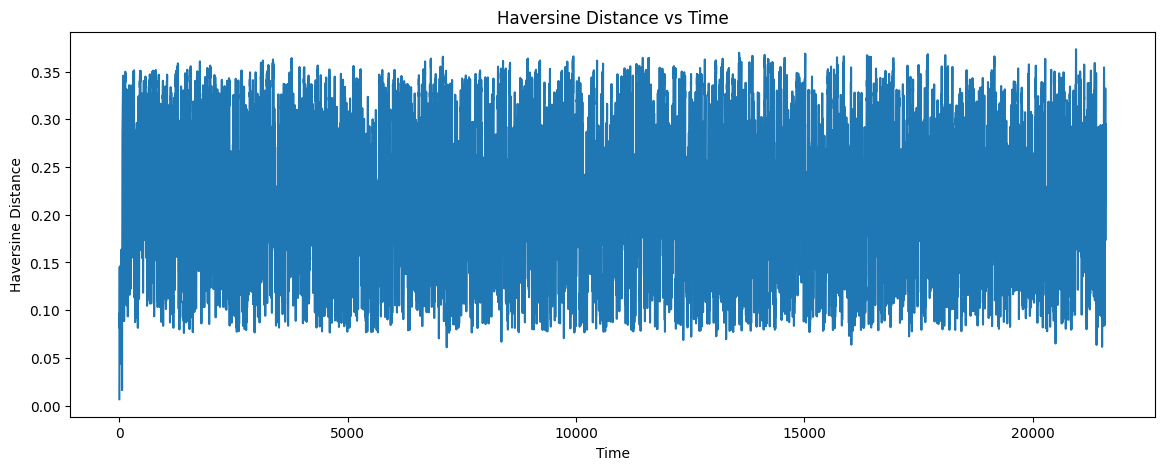

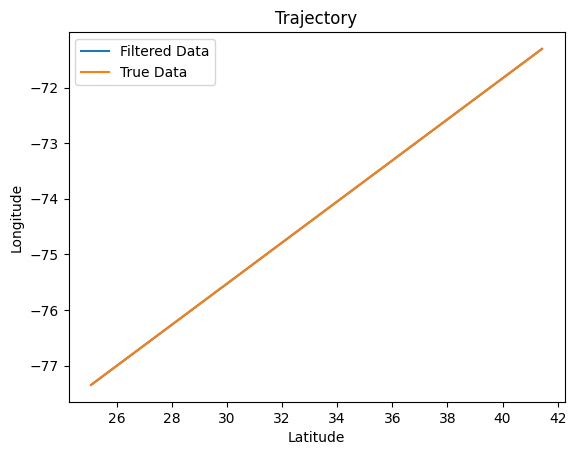

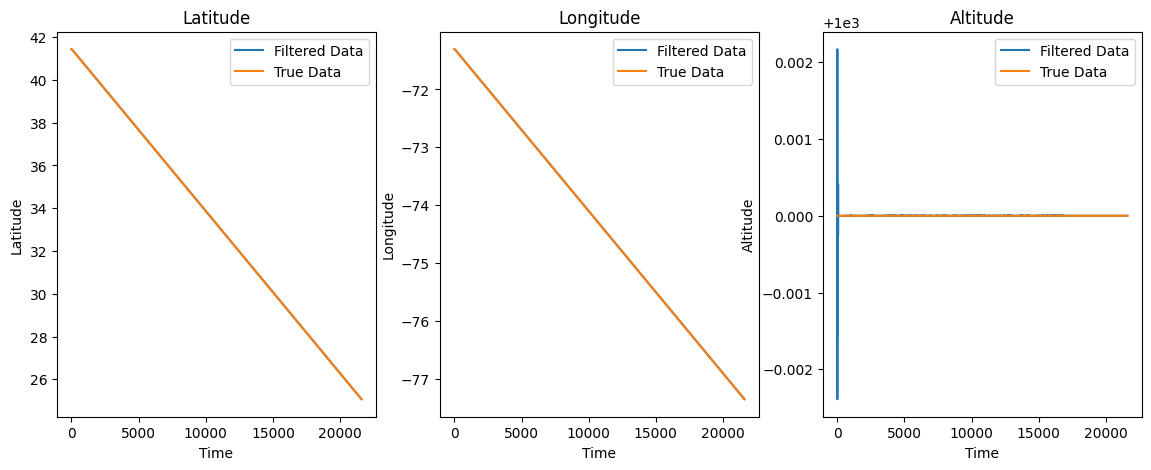

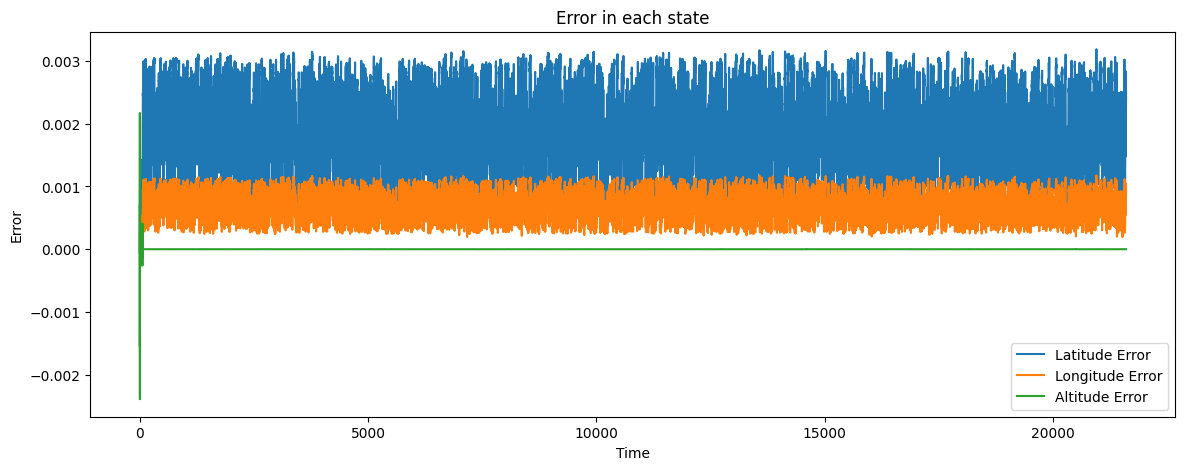

In [2]:
# Full State Implementation
simulation.simulate(r"trajectory_data.csv","full_state")

##### Discussion on implementation
Overall, error-state implementation provided better accuracy in terms of haversine metrics. This is understandable considering the errors are quickly taken into consideration and nullified. Although it may work for smaller datasets, full state implementation provides a better estimate on a larger data as the bias terms update with respect to system whereas the bias is constant in error state system.

##### Tuning Bias, Noise, and Covariance
The first guess for bias within the propagation model was drawn based on the values of IMU. The force is majorly acting in Z, acceleration due to gravity and the value seems to be stable thus small bias was given from 0.001 - 0.01. Similarly small bias was given to Gyroscope readings as the values were in the scale of $10^{-5}$. Final bias was selected to be 0.01 for error state model which was constant.

The bias in the full state was selected based on the haversine distance error. A very high intial bias gave good results thus, varying the bias from 0.1 - 10, the value was narrowed down to 1. 

Noise was varied based on the haversine error in the range 0.1 - 20, a higher noise gave better result thus the value was selected to be 10 across for biases.

Covariance for this project was to be set for position and velocity. Again the matrix was tuned to provide lower haversine error, the diagonal matrix R was checked from values 0.01 - 1 and final value was narrowed to $0.1 * I_{3 \times 3}$.

Using a GNSS-based INS system implies dependence on GNSS signal quality. Signal loss or degradation can significantly impact filter performance. The accuracy can be improved by taking GPS data from multiple satellites for error correction. Involving Multi-Frequency signals to ensure that only signals are taken from satellite directly and not from the reflection.

##### Discussion on Haversine Error
Haversine formula calculates the great-circle distance between two points on a sphere, which is a reasonable approximation for short distances on Earth. However, it is not ideal for comparing GNSS and INS errors.

Haversine only provides distance, not direction of the error. Real-world GNSS errors can have a directional bias. Haversine assumes a perfect sphere, whereas Earth is an oblate spheroid. This can lead to minor inaccuracies for long distances. Statistical methods such as RMSE would provide a better estimate at individual state level.